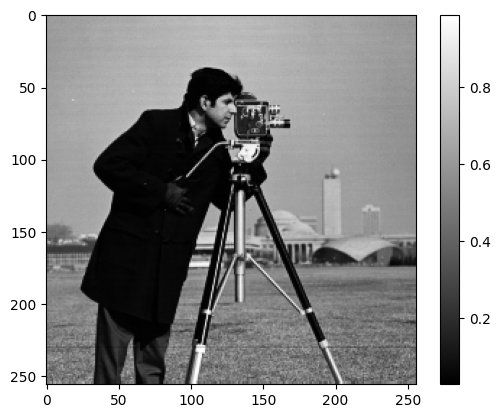

In [51]:
# 1(a)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request
from PIL import Image

# Read the image from the URL
url = 'http://www.cs.ucl.ac.uk/staff/S.Arridge/teaching/optimisation/CW2/Cameraman256.png'

with urllib.request.urlopen(url) as url_response:
    with Image.open(url_response) as img:
        im = np.array(img)

# Convert to float and normalize to [0, 1] range
im = np.float32(im)/255.0

# Display the image with a gray colormap and colorbar
imgplot = plt.imshow(im, cmap='gray')
plt.colorbar()
plt.show()


In [54]:
# 1(b)
from scipy.ndimage import gaussian_filter

def apply_convolution(f, sigma, theta):
    # Apply Gaussian filter
    gf = gaussian_filter(f, sigma)
    
    # Add noise to blurred image
    w, h = gf.shape
    noise = np.random.randn(w, h)
    gf = gf + theta * noise
    
    return gf  


In [41]:
# 1(c)
import scipy.sparse as sparse
import scipy.sparse.linalg as splinalg

def ATA_operator(f, sigma, alpha):
    # Apply A^T A + alpha*I operator to f
    Af = gaussian_filter(f, sigma) 
    ATAf = gaussian_filter(Af, sigma)
    return ATAf + alpha * f

# def ATA(f, sigma, alpha):
#     # Compute A.TA(f) using Gaussian convolution
#     Af = gaussian_filter(f, sigma)
#     Af = Af.reshape(-1, 1)
#     ATAf = gaussian_filter(Af.reshape(f.shape), sigma)
#     ATAf = (ATAf + alpha * f).reshape(-1)
#     return ATAf

def deconvolve_normal_equations(g, sigma, alpha):
    # Set up linear operator for ATA
    M, N = g.shape
    A = sparse.linalg.LinearOperator((M*N, M*N), matvec=lambda x: np.ravel(ATA_operator(x.reshape(g.shape), sigma, alpha)))

    # Compute ATg
    # ATg = gaussian_filter(g, sigma).flatten()
    ATg = np.ravel(g)

    # Solve linear system using GMRES
    f_alpha, info = splinalg.gmres(A, ATg)

    return f_alpha.reshape((M, N))

def normal_info(g, sigma, alpha):
    # Set up linear operator for ATA
    M, N = g.shape
    A = sparse.linalg.LinearOperator((M*N, M*N), matvec=lambda x: np.ravel(ATA_operator(x.reshape(g.shape), sigma, alpha)))

    # Compute ATg
    # ATg = gaussian_filter(g, sigma).flatten()
    ATg = np.ravel(g)

    # Solve linear system using GMRES
    f_alpha, info = splinalg.gmres(A, ATg)

    return info

# def deconvolve_normal_equations(g, sigma, alpha, maxiter=100, tol=1e-6):
#     # Define linear operator for ATA
#     ATA_op = lambda x: ATA(x.reshape(g.shape), sigma, alpha)

#     # Vectorize g for use in GMRES
#     g_vec = g.reshape(-1)

#     # Solve normal equations using GMRES
#     A = sparse.linalg.LinearOperator((g_vec.size, g_vec.size), matvec=ATA_op, dtype=g.dtype)
#     f_vec, info = sparse.linalg.gmres(A, g_vec, tol=tol, maxiter=maxiter)
#     f = f_vec.reshape(g.shape)

#     return f

In [42]:
# 1(d)
# def M_f(f):
#     # Implementation of the augmented matrix multiplication
#     Af = gaussian_filter(f, sigma)
#     Af = Af.flatten().reshape((-1, 1))
#     zeros = np.zeros((f.size, 1))
#     zeros = zeros.reshape((-1, 1))
#     Mf = np.vstack((Af, np.sqrt(alpha) * zeros))
#     return Mf.flatten()

def M_f(f):
    # Implementation of the augmented matrix multiplication
    y = gaussian_filter(f, sigma)
    z = gaussian_filter(y, sigma)
    M_f = np.vstack([np.ravel(z), np.sqrt(alpha)*np.ravel(f)])
    return M_f

# def MT_b(b):
#     # Implementation of the transposed augmented matrix multiplication
#     M, N = g.shape
#     f = b[:M*N].reshape((M, N))
#     ATg = gaussian_filter(f, sigma, mode='constant', cval=0)
#     ATg = gaussian_filter(ATg, sigma, mode='constant', cval=0)
#     zeros = np.zeros((M, N))
#     MTb = np.hstack((ATg.flatten().reshape((-1, 1)), np.sqrt(alpha) * zeros.flatten().reshape((-1, 1))))
#     return MTb.flatten()

def MT_b(b):
    # Implementation of the transposed augmented matrix multiplication
    global g
    M, N = g.shape
    g_vec = b[:M*N]
    f_vec = b[M*N:]
    g = np.reshape(g_vec, (M, N))
    y = gaussian_filter(g, sigma)
    z = gaussian_filter(y, sigma)
    MT_b = np.ravel(z) + np.sqrt(alpha)*np.ravel(f_vec)
    return MT_b

def solve_augmented_equations(g, sigma, alpha):
    # Define linear operator for lsqr
    M, N = g.shape
    size = M*N
    A = sparse.linalg.LinearOperator((2*size, size), matvec=M_f, rmatvec=MT_b)

    # Concatenate g with a zero vector
    b = np.vstack([np.reshape(g,(size,1)), np.zeros((size, 1))])
    
    # Solve linear system using lsqr
    f_lsqr= splinalg.lsqr(A, b)[0]

    return f_lsqr[:g.size].reshape(g.shape)

def augmented_info(g, sigma, alpha):
    # Define linear operator for lsqr
    M, N = g.shape
    size = M*N
    A = sparse.linalg.LinearOperator((2*size, size), matvec=M_f, rmatvec=MT_b)

    # Concatenate g with a zero vector
    b = np.vstack([np.reshape(g,(size,1)), np.zeros((size, 1))])
    
    # Solve linear system using lsqr
    info = splinalg.lsqr(A, b)[1]

    return info

Method c: Converged in 0 iterations (0.04467940330505371 seconds)
Method d: Converged in 2 iterations (0.05343961715698242 seconds)


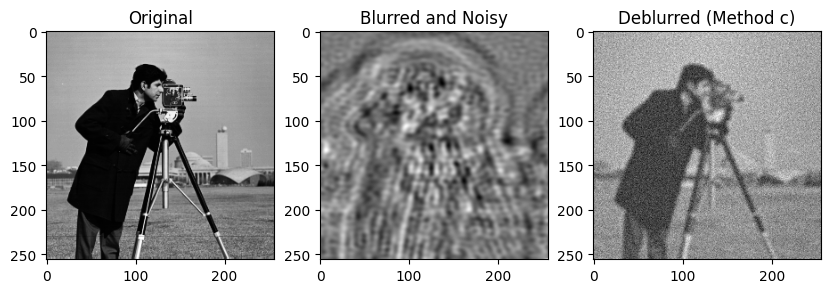

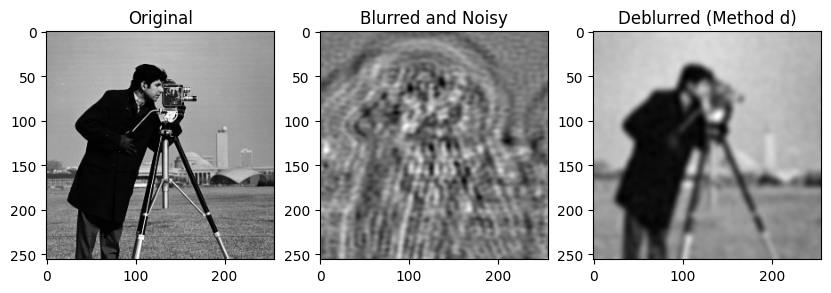

In [68]:
# 1e)
import time
import matplotlib.pyplot as plt

sigma = 2.0
theta = 0.05
g = apply_convolution(im, sigma, theta)

def convolve_and_add_noise(alpha):
    global sigma, theta, g
    # Deconvolve using normal equations (method c)
    tc1 = time.time()
    f_alpha = deconvolve_normal_equations(g, sigma, alpha);
    tc2 = time.time()
    info = normal_info(g, sigma, alpha) 
    print('Method c: Converged in {} iterations ({} seconds)'.format(info, tc2-tc1))

    # Deconvolve using augmented equations (method d)
    alpha = 0.01
    td1 = time.time()
    f_aug = solve_augmented_equations(g, sigma, alpha);
    td2 = time.time()
    info = augmented_info(g, sigma, alpha)
    print('Method d: Converged in {} iterations ({} seconds)'.format(info, td2-td1))

    # Display results
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].imshow(im, cmap='gray')
    ax[0].set_title('Original')
    ax[1].imshow(g, cmap='gray')
    ax[1].set_title('Blurred and Noisy')
    ax[2].imshow(f_alpha, cmap='gray')
    ax[2].set_title('Deblurred (Method c)')
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].imshow(im, cmap='gray')
    ax[0].set_title('Original')
    ax[1].imshow(g, cmap='gray')
    ax[1].set_title('Blurred and Noisy')
    ax[2].imshow(f_aug, cmap='gray')
    ax[2].set_title('Deblurred (Method d)')
    plt.show()

alpha = 1
convolve_and_add_noise(alpha)


In [100]:
# 2a
from scipy.optimize import root,brentq

# method c

def discrepancy_function_nor(alpha, g, sigma):
    # Compute the residual
    f_alpha = deconvolve_normal_equations(g, sigma, alpha)
    r_alpha = apply_convolution(f_alpha, sigma, 0) - g
    
    r_norm = np.linalg.norm(r_alpha)

    # Compute the discrepancy principle
    n = g.size
    sigma_sq = (r_norm / np.sqrt(n))**2
    dp = 1/n * r_norm**2 - sigma_sq
    
    return dp

def find_optimal_alpha_dp_nor(g, sigma):
    # Set up alpha range
    alpha_min = 1e-5
    alpha_max = 1
    
    # Find the value of alpha that gives the zero of the DP(alpha) function
    try:
        # alpha_dp = brentq(discrepancy_function_nor, alpha_min, alpha_max, args=(g, sigma))
        alpha_dp = root(discrepancy_function_nor, alpha_min, args=(g, sigma)).x[0]

        print("Optimal alpha value using Discrepancy Principle for deconvolution using normal equations: ", alpha_dp)
    except ValueError:
        print("Failed to find optimal alpha using Discrepancy Principle.")
    return alpha_dp

alpha_dp_c = find_optimal_alpha_dp_nor(g,sigma)


# method d

def discrepancy_function_aug(alpha, g, sigma):
    # Compute the residual
    f_alpha = solve_augmented_equations(g, sigma, alpha)
    r_alpha = apply_convolution(f_alpha, sigma, 0) - g
    r_norm = np.linalg.norm(r_alpha)

    # Compute the discrepancy principle
    n = g.size
    sigma_sq = (r_norm / np.sqrt(n))**2
    dp = 1/n * r_norm**2 - sigma_sq
    
    return dp

def find_optimal_alpha_dp_aug(g, sigma):
    # Set up alpha range
    alpha_min = 1e-2
    alpha_max = 1
    
    # Find the value of alpha that gives the zero of the DP(alpha) function
    try:
        # alpha_dp = brentq(discrepancy_function_aug, alpha_min, alpha_max, args=(g, sigma))
        alpha_dp = root(discrepancy_function_aug, alpha_min, args=(g, sigma)).x[0]
        print("Optimal alpha value using Discrepancy Principle for deconvolution using augmented equations: ", alpha_dp)
    except ValueError:
        print("Failed to find optimal alpha using Discrepancy Principle.")
    return alpha_dp

alpha_dp_d = find_optimal_alpha_dp_aug(g,sigma)



Optimal alpha value using Discrepancy Principle for deconvolution using normal equations:  1e-05
Optimal alpha value using Discrepancy Principle for deconvolution using augmented equations:  0.01


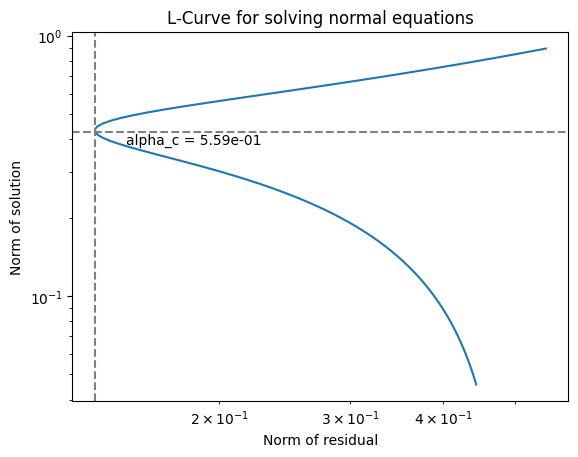

In [98]:
# 2b

# Define range of alpha values to test
alphas = np.logspace(-1, 1, num=100)

# method c
def l_curve(g, sigma, alphas, deconvolve_fun):
    norm_f = []
    norm_residual = []
    
    
    for alpha in alphas:
        if deconvolve_fun == 'normal equations':
            # Compute f for current alpha
            f_alpha = deconvolve_normal_equations(g, sigma, alpha)
        elif deconvolve_fun == 'augmented equations':
            print('L-curve is not applicable to augmented equations method')
        # Compute residual and f norms
        r_alpha = g - f_alpha #gaussian_filter(f_alpha, sigma)
        norm_f.append(np.linalg.norm(f_alpha))
        norm_residual.append(np.linalg.norm(r_alpha))
        

    return norm_f, norm_residual

# Compute the L-curve
norm_f_nor, norm_residual_nor = l_curve(g, sigma, alphas, 'normal equations')


def plot_l_curve(norm_f, norm_residual, deconvolve_fun):
    assert alpha_l_c == 'normal equations', 'L-curve is not applicable to augmented equations method'
    # Plot the L-curve
    import matplotlib.pyplot as plt
    plt.loglog(norm_residual, norm_f)
    plt.xlabel('Norm of residual')
    plt.ylabel('Norm of solution')
    plt.title('L-Curve for solving {}'.format(deconvolve_fun))

    # Find the optimal alpha value based on the L-curve
    curvature = []
    for i in range(1, len(alphas)-1):
        dx1 = norm_residual[i] - norm_residual[i-1]
        dy1 = norm_f[i] - norm_f[i-1]
        dx2 = norm_residual[i+1] - norm_residual[i]
        dy2 = norm_f[i+1] - norm_f[i]
        curvature.append(abs(dx1*dy2 - dx2*dy1) / ((dx1**2 + dy1**2)**1.5 * (dx2**2 + dy2**2)**1.5))

    optimal_index = np.argmax(curvature) + 1
    alpha_l = alphas[optimal_index]

    # Plot the optimal alpha value
    plt.axvline(norm_residual[optimal_index], linestyle='--', color='gray')
    plt.axhline(norm_f[optimal_index], linestyle='--', color='gray')
    plt.text(norm_residual[optimal_index]*1.1, norm_f[optimal_index]*0.9, 'alpha_c = {:.2e}'.format(alpha_l))

    plt.show()
    return alpha_l

alpha_l_c = plot_l_curve(norm_f_nor, norm_residual_nor, 'normal equations')

In [102]:
# 2(c) results using these two optimal alphas.
# DP method c
convolve_and_add_noise(alpha_dp_c)

In [ ]:
# DP method d
convolve_and_add_noise(alpha_dp_d)

In [ ]:
# l-curve method c
convolve_and_add_noise(alpha_l_c)